# Vortices in Potential Flow

In this notebook we will produce sample data using potential flow as a numerical laboratory to experiment and prototype different vorticy identifying techniques. In this particular example, we will focus on the FTLE method.

For the derivation of the equations used in this computation, refer to the potential flow notes at https://goo.gl/J2BmKz

-- Richard Galvez, May 2015
https://github.com/richardagalvez/Vortices-Python/blob/master/Vortex-FTLE.ipynb

____________________________________________________________________________________

In [1]:
import os; os.chdir("../../"); print("Current working directory:", work_dir := os.getcwd())

Current working directory: /home/wilf/Desktop/python_workspace/PCD_SM-Fluid-Pred


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from the_well.data import WellDataset
from data.the_Well.dataset import theWellTorchDataset as DataModule
import numpy as np

device = "cpu"
data_path = "data/_pipeline_"  # path/to/storage
data_path = os.path.join(work_dir, data_path)

dataset_name = "turbulent_radiative_layer_2D" # "turbulent_radiative_layer_2D", "MHD_64"

in_len = 60
out_len = 1
start_time = 50

dataset = WellDataset(
    well_base_path=os.path.join(data_path, "datasets"),
    well_dataset_name=dataset_name,
    well_split_name="test",
    n_steps_input=in_len,
    n_steps_output=out_len,
    use_normalization=False,
)

test_data = DataModule(work_dir=work_dir, dataset_name=dataset_name, input_len=in_len, output_len=out_len, kind="train")

test_data.init(dict(reshape=True, normalize=False, subsampling_factor=2))

input, output = test_data[0]

z_slice = 15

if dataset_name == "turbulent_radiative_layer_2D":
    u, v = input[start_time:, 2, ...], input[start_time:, 3, ...]
if dataset_name == "MHD_64":
    u, v = input[start_time:, 4, :, :, z_slice], input[start_time:, 5, :, :, z_slice]

u, v = np.array(u), np.array(v)

print(u.shape)
print(v.shape)

(10, 64, 192)
(10, 64, 192)


In [4]:
from scipy.interpolate import RegularGridInterpolator

class VelocityInterpolator:
    def __init__(self, u, v):
        self.time_axis = np.arange(u.shape[0])  # e.g., [0, 1, ..., T-1]
        self.u_interp = RegularGridInterpolator((self.time_axis, np.arange(u.shape[1]), np.arange(u.shape[2])), u, bounds_error=False, fill_value=None)
        self.v_interp = RegularGridInterpolator((self.time_axis, np.arange(v.shape[1]), np.arange(v.shape[2])), v, bounds_error=False, fill_value=None)

    def eval(self, t):
        """Interpolate u and v at fractional time t. Returns (u_t, v_t) of shape (Lx, Ly)"""
        Lx, Ly = self.u_interp.grid[1].size, self.u_interp.grid[2].size
        # Build grid of points: (Lx*Ly, 3) with (t, x, y)
        X, Y = np.meshgrid(np.arange(Lx), np.arange(Ly), indexing='ij')
        points = np.stack([np.full_like(X, t, dtype=np.float32), X, Y], axis=-1).reshape(-1, 3)
        u_t = self.u_interp(points).reshape(Lx, Ly)
        v_t = self.v_interp(points).reshape(Lx, Ly)
        return u_t, v_t


U = VelocityInterpolator(u, v)


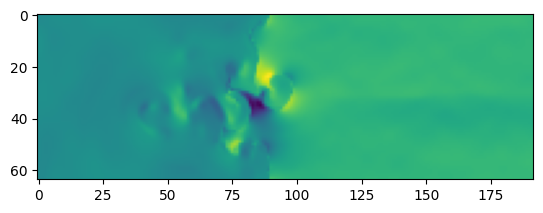

In [5]:
import matplotlib.pyplot as plt

test_time = 5

plt.imshow(u[test_time])
plt.show()

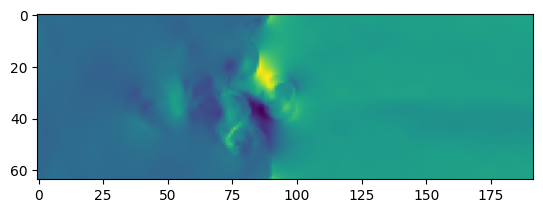

In [6]:
test_time = 5.55
u_t, v_t = U.eval(test_time)

plt.imshow(u_t)
plt.show()

In [7]:
import numpy
from matplotlib import pyplot
import sys

%matplotlib inline

## FTLE Method

We first investigate the case of a single vortex in the presence of a stream whos strength depends on x. 

I meant to do just a uniform freestream but accidentally made it depend on x. Actually, it ends up producing interesting dynamics.

Let's start by defining the mesh (we'll also keep the same mesh for the various examples): 


In [8]:
import numpy as np

ratio = int(u.shape[2] / u.shape[1])
H, W = u.shape[1:3]

if W / H >= ratio:
    y_span = 1
    x_span = ratio * y_span
else:
    x_span = 1
    y_span = x_span / ratio

# Define x and y ranges centered around 0
x = np.linspace(0, x_span, W)
y = np.linspace(0, y_span, H)

# Generate meshgrid
X, Y = np.meshgrid(x, y)

In [9]:
W

192

In [10]:
x_start, x_end = 0, x_span
y_start, y_end = 0, y_span

In [11]:
y_end

1

In [12]:
x_end

3

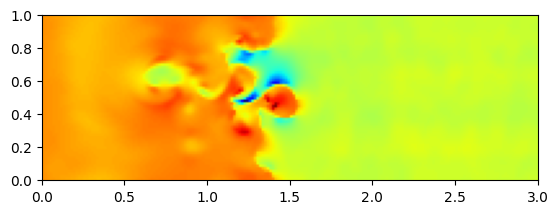

In [13]:
import matplotlib.pyplot as plt

test_time = 5

plt.imshow(v[test_time], extent=(x_start, x_end, y_start, y_end), origin='lower', cmap='jet')
plt.show()

The u and v fields for the vortex are first computed and then the faux freestream addition is included. Also notice we used the superposition property of potential flow theory in this situation. 

### Stream plot

We can visualize the flow produced by this configuration by looking at a stream plot of the u and v fields:


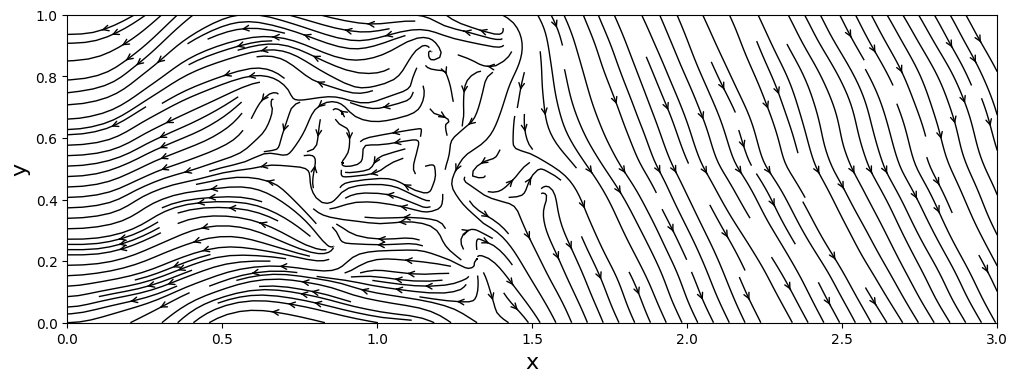

In [14]:
size = 12 # Size of the image displayed only in this notebook.

test_time = 5

fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
    
pyplot.streamplot(X, Y, u[test_time], v[test_time], density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
# pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=40, marker='o')
pyplot.draw()
pyplot.show()


And the quiver:

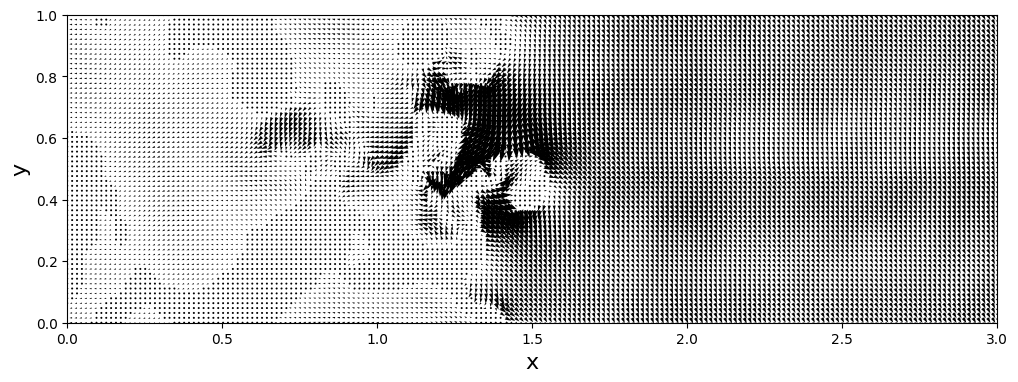

In [15]:


test_time = 5


fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)                                                           
    
pyplot.quiver(X, Y, u[test_time], v[test_time], linewidth=1, color='k')
pyplot.draw()
pyplot.show()


###Trajectory analysis

To be sure that our FTLE code is calculating the correct trajectories, we can first plot some and see how they look.

In order to do that, the first step is to define a bilinear interpolation function http://en.wikipedia.org/wiki/Bilinear_interpolation. 

One interesting thing to notice here is how I took care of the boundary conditions. In this first naive run through, I simply decided that if the point lied outside of the boundaries of our space, then it should take the value that it had at the boundary.

In [16]:
def bilinear_interpolation(X, Y, f, x, y):
    """Returns the approximate value of f(x,y) using bilinear interpolation.

    Arguments
    ---------
    X, Y -- mesh grid.
    f -- the function f that should be an HxW matrix.
    x, y -- coordinates where to compute f(x,y)
    """
    H, W = numpy.shape(X)  # Get the actual dimensions of the grid

    # Ensure that x and y are within the grid bounds and replicate boundary values
    if x < X[0, 0]:
        x = X[0, 0]  # Replicate the left boundary
    elif x > X[-1, -1]:
        x = X[-1, -1]  # Replicate the right boundary

    if y < Y[0, 0]:
        y = Y[0, 0]  # Replicate the bottom boundary
    elif y > Y[-1, -1]:
        y = Y[-1, -1]  # Replicate the top boundary

    # Compute grid spacings
    dx, dy = X[0, 1] - X[0, 0], Y[1, 0] - Y[0, 0]

    # Compute indices for interpolation
    i1, i2 = int((x - X[0, 0]) / dx), int((x - X[0, 0]) / dx) + 1
    j1, j2 = int((y - Y[0, 0]) / dy), int((y - Y[0, 0]) / dy) + 1

    # Ensure indices are within bounds
    i1, i2 = max(0, min(i1, W-1)), max(0, min(i2, W-1))
    j1, j2 = max(0, min(j1, H-1)), max(0, min(j2, H-1))

    # Interpolation logic
    x1, x2 = X[j1, i1], X[j2, i2]
    y1, y2 = Y[j1, i1], Y[j2, i2]

    # Bilinear interpolation formula
    f_interpolated = ( 1/(x2 - x1) * 1/(y2 - y1) *
                       (f[j1, i1] * (x2 - x) * (y2 - y) +
                        f[j1, i2] * (x - x1) * (y2 - y) +
                        f[j2, i1] * (x2 - x) * (y - y1) +
                        f[j2, i2] * (x - x1) * (y - y1)))

    # If the result is NaN, return the boundary value
    if numpy.isnan(f_interpolated):
        return f[j1, i1]  # Replicate the value at the nearest grid point

    return f_interpolated


The next thing we will need is a Runge-Kutta integrator to 4th order. I found that the use of this integrator was good enough for our purposes. In the near future however, it might be a good idea to implement an adaptive time feature.

In [17]:
def rk4(X, Y, x, y, f, h, dim):
    """Returns the approximate value of f(x,y) using RK4.

    Arguments
    ---------
    X, Y -- mesh grid.
    x, y -- coordinates where to begin the evolution.
    f -- the function f that will be evolved.
    h -- the time step (usually referred to as dt).
    dim -- 0 for x and 1 for y.
    """

    # Compute k1, k2, k3, k4
    k1 = h * bilinear_interpolation(X, Y, f, x, y)
    if numpy.isnan(k1): k1 = 0
    k2_x = x + 0.5 * h
    k2_y = y + 0.5 * k1
    k2 = h * bilinear_interpolation(X, Y, f, k2_x, k2_y)
    if numpy.isnan(k2): k2 = 0
    k3_x = x + 0.5 * h
    k3_y = y + 0.5 * k2
    k3 = h * bilinear_interpolation(X, Y, f, k3_x, k3_y)
    if numpy.isnan(k3): k3 = 0
    k4_x = x + h
    k4_y = y + k3
    k4 = h * bilinear_interpolation(X, Y, f, k4_x, k4_y)
    if numpy.isnan(k4): k4 = 0

    # Final result based on the dimension
    if dim == 0:
        return x + 1./6 * k1 + 1./3 * k2 + 1./3 * k3 + 1./6 * k4
    elif dim == 1:
        return y + 1./6 * k1 + 1./3 * k2 + 1./3 * k3 + 1./6 * k4
    else:
        sys.exit("Invalid dimension parameter passed to rk4")


We next define a function that tests that the trajectories 

a) follow the flow lines, and

b) are integrated long enough to sample the domain.

In [18]:
def generate_colors(n):
    cmap = plt.get_cmap('hsv')
    return [cmap(i / n) for i in range(n)]


def test_trajectory(X, Y, u, v, integration_time, dt):
    """ Plots the trajectories of a few particles
    
    Arguments
    ---------
    X, Y -- mesh grid.
    i, j -- indices of the first particle on the mesh.
    integration_time -- the duration of the integration
    dt -- the finess of the time integration space.
    
    """

    H, W = numpy.shape(X)
    num_points = 5
    color_list = generate_colors(num_points)

    points = np.column_stack((np.random.randint(0, H, size=num_points), np.random.randint(0, W, size=num_points)))
    j, i = points[0, 0], points[0, 1]



    fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))

    pyplot.xlim(x_start-.5, x_end+.5)
    pyplot.ylim(y_start-.5, y_end+.5)

    xs, ys = X[j,i], Y[j, i]

    traj_x , traj_y = numpy.zeros((H,W)), numpy.zeros((H,W))

    traj_x[j][i], traj_y[j][i] = xs, ys

    

    for point, color in zip(points, color_list):

        for k in range(0, int(integration_time/dt)):
        
            xs, ys = rk4(X, Y, xs, ys, u, dt, 0), rk4(X, Y, xs, ys, v, dt, 1)
            traj_x[j][i] += xs
            traj_y[j][i] += ys
    
            #print '(xs, ys) ->', xs, ys
            pyplot.scatter(xs, ys, s=5, color=color)
            #print k*dt
        
        j, i = point[0], point[1]

        xs, ys = X[j,i], Y[j, i]
    
    pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')



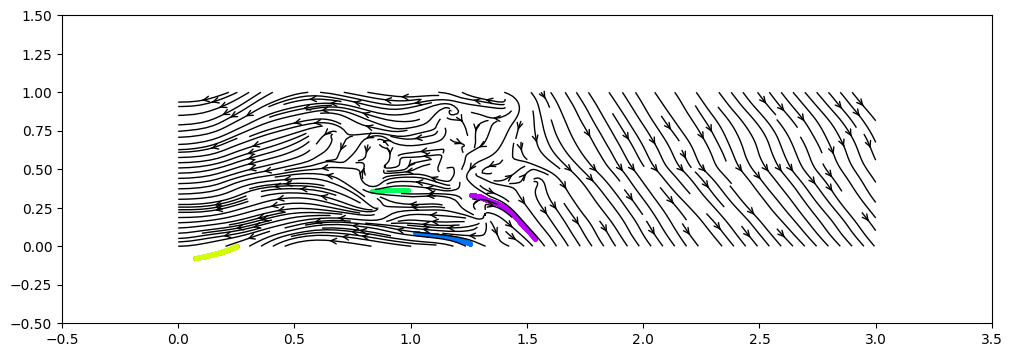

In [19]:
test_time = 5
test_trajectory(np.array(X), np.array(Y), u[test_time], v[test_time], 5, 0.01)
plt.show()

In [20]:
def generate_colors(n):
    cmap = plt.get_cmap('hsv')
    return [cmap(i / n) for i in range(n)]


def test_trajectory_time_interp(X, Y, U, integration_time, dt, num_points = 10):

    H, W = numpy.shape(X)

    color_list = generate_colors(num_points)

    points = np.column_stack((np.random.randint(0, H, size=num_points), np.random.randint(0, W, size=num_points)))
    j, i = points[0, 0], points[0, 1]

    fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))

    pyplot.xlim(x_start-.5, x_end+.5)
    pyplot.ylim(y_start-.5, y_end+.5)

    xs, ys = X[j,i], Y[j, i]

    traj_x , traj_y = numpy.zeros((H,W)), numpy.zeros((H,W))

    traj_x[j][i], traj_y[j][i] = xs, ys

    for point, color in zip(points, color_list):

        for k in range(0, int(integration_time/dt)):

            time = k * dt
            u_t, v_t = U.eval(time)

            xs, ys = rk4(X, Y, xs, ys, u_t, dt, 0), rk4(X, Y, xs, ys, v_t, dt, 1)
            traj_x[j][i] += xs
            traj_y[j][i] += ys

            #print '(xs, ys) ->', xs, ys
            pyplot.scatter(xs, ys, s=5, color=color)
            #print k*dt

        j, i = point[0], point[1]


        xs, ys = X[j,i], Y[j, i]

    pyplot.streamplot(X, Y, u_t, v_t, density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')



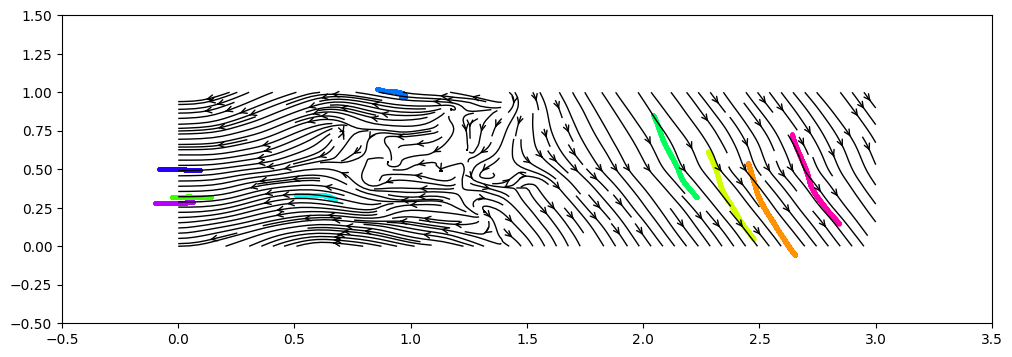

In [21]:
test_trajectory_time_interp(np.array(X), np.array(Y), U, 4.5, 0.01, num_points=10)
plt.show()

In [22]:
from tqdm import tqdm

def get_traj(X, Y, u, v, integration_time, dt):
    """ Returns the FTLE particle trajectory
    
    Arguments
    ---------
    x, y -- mesh grid coordinates
    dt -- integral time step
    """
    x = X[0,:]
    y = Y[:,0]
    
    traj_x = numpy.zeros((H,W))
    traj_y = numpy.zeros((H,W))
    
    for i, xx in tqdm(enumerate(x)):
        for j, yy in enumerate(y):
            xs, ys = xx, yy
            traj_x[j][i], traj_y[j][i] = xs, ys
            for k in range(0, int(integration_time/dt)):

                xs, ys = rk4(X, Y, xs, ys, u, dt, 0), rk4(X, Y, xs, ys, v, dt, 1) 
                traj_x[j][i] += xs
                traj_y[j][i] += ys
                 
    return traj_x, traj_y

def get_traj_time_interp(X, Y, U, integration_time, dt):

    x = X[0,:]
    y = Y[:,0]

    traj_x = numpy.zeros((H,W))
    traj_y = numpy.zeros((H,W))

    u_fields = []
    v_fields = []
    for k in range(0, int(integration_time/dt)):
        u_t, v_t = U.eval(k * dt)
        u_fields.append(u_t)
        v_fields.append(v_t)

    # Particle advection using precomputed velocity fields
    for i, xx in tqdm(enumerate(x)):
        for j, yy in enumerate(y):
            xs, ys = xx, yy
            traj_x[j][i], traj_y[j][i] = xs, ys
            for k in range(0, int(integration_time/dt)):
                u_t = u_fields[k]
                v_t = v_fields[k]
                xs = rk4(X, Y, xs, ys, u_t, dt, 0)
                ys = rk4(X, Y, xs, ys, v_t, dt, 1)
                traj_x[j][i] += xs
                traj_y[j][i] += ys

    return traj_x, traj_y

In [23]:
u.shape

(10, 64, 192)

In [24]:
H

64

And now that we have the trajectories, we can calculate the FTLE field

In [25]:
def get_ftle(traj_x, traj_y, X, Y, integration_time):
    """ Returns the FTLE scalar field

    Mostly adapted from Steven's FTLE code (GitHub user stevenliuyi)

    Arguments
    ---------
    traj_x, traj_y -- The trajectories of the FTLE particles
    X, Y -- Meshgrid
    integration_time -- the duration of the integration time

    """
    ftle = numpy.zeros((H,W))

    for i in range(0, W):
        for j in range(0, H):
            # index 0:left, 1:right, 2:down, 3:up
            xt = numpy.zeros(4)  # Adjusted to size 4
            yt = numpy.zeros(4)  # Adjusted to size 4
            xo = numpy.zeros(2)
            yo = numpy.zeros(2)

            # Handling boundaries for i (columns)
            if (i == 0):  # Left boundary
                xt[0] = traj_x[j][i]; xt[1] = traj_x[j][i+1]
                yt[0] = traj_y[j][i]; yt[1] = traj_y[j][i+1]
                xo[0] = X[j][i];      xo[1] = X[j][i+1]
            elif (i == W-1):  # Right boundary
                # For rightmost point, ensure no duplication and avoid using the last point twice
                xt[0] = traj_x[j][i-1]; xt[1] = traj_x[j][i]
                yt[0] = traj_y[j][i-1]; yt[1] = traj_y[j][i]
                xo[0] = X[j][i-1]; xo[1] = X[j][i]
                xt[2] = traj_x[j][i]; xt[3] = traj_x[j][i]
                yt[2] = traj_y[j][i]; yt[3] = traj_y[j][i]
                yo[0] = Y[j][i]; yo[1] = Y[j][i]
            else:  # Interior points
                xt[0] = traj_x[j][i-1]; xt[1] = traj_x[j][i+1]
                yt[0] = traj_y[j][i-1]; yt[1] = traj_y[j][i+1]
                xo[0] = X[j][i-1]; xo[1] = X[j][i+1]

            # Handling boundaries for j (rows)
            if (j == 0):  # Bottom boundary
                xt[2] = traj_x[j][i]; xt[3] = traj_x[j+1][i]
                yt[2] = traj_y[j][i]; yt[3] = traj_y[j+1][i]
                yo[0] = Y[j][i]; yo[1] = Y[j+1][i]
            elif (j == H-1):  # Top boundary
                xt[2] = traj_x[j-1][i]; xt[3] = traj_x[j][i]
                yt[2] = traj_y[j-1][i]; yt[3] = traj_y[j][i]
                yo[0] = Y[j-1][i]; yo[1] = Y[j][i]
            else:  # Interior points
                xt[2] = traj_x[j-1][i]; xt[3] = traj_x[j+1][i]
                yt[2] = traj_y[j-1][i]; yt[3] = traj_y[j+1][i]
                yo[0] = Y[j-1][i]; yo[1] = Y[j+1][i]

            lambdas = eigs(xt, yt, xo, yo)

            if np.any(np.isnan(lambdas)):
                ftle[j][i] = float('nan')
            else:
                ftle[j][i] = .5 * numpy.log(max(lambdas)) / (integration_time)

    return ftle

In [26]:
def eigs(xt, yt, xo, yo):
    ftlemat = numpy.zeros((2,2))
    ftlemat[0][0] = (xt[1]-xt[0])/(xo[1]-xo[0])
    ftlemat[1][0] = (yt[1]-yt[0])/(xo[1]-xo[0])
    ftlemat[0][1] = (xt[3]-xt[2])/(yo[1]-yo[0])
    ftlemat[1][1] = (yt[3]-yt[2])/(yo[1]-yo[0])
    
    if (True in numpy.isnan(ftlemat)): 
        return 'nan'
    
    ftlemat = numpy.dot(ftlemat.transpose(), ftlemat)
    w, v = numpy.linalg.eig(ftlemat)

    return w

## FTLE results

First we take a look at the x-dependent stream mixed with the center placed vortex.

192it [05:07,  1.60s/it]


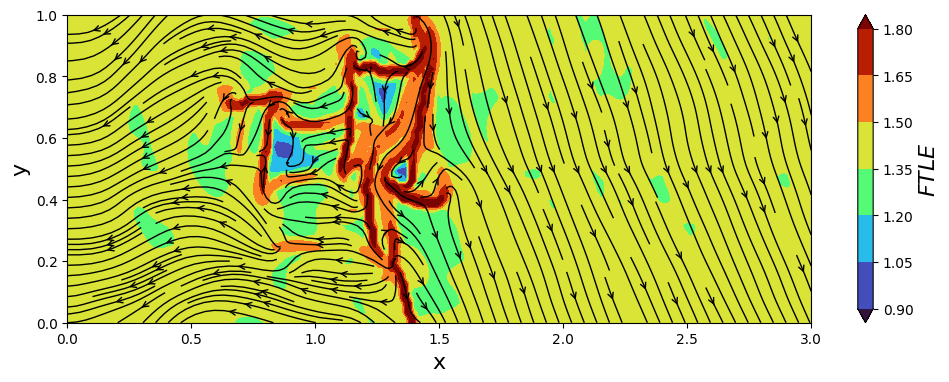

In [27]:
integration_time, dt = 4.5, .01   # 5, .01

test_time = 5

traj_x, traj_y = get_traj(X, Y, u[test_time], v[test_time], integration_time, dt)
ftle = get_ftle(traj_x, traj_y, X, Y, integration_time)

    
fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)                                                           
    
contf = pyplot.contourf(X, Y, ftle, extend='both', cmap='turbo')
cbar = pyplot.colorbar(contf)

cbar.set_label('$FTLE$', fontsize=16)
pyplot.streamplot(X, Y, u[test_time], v[test_time], density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
pyplot.draw()
pyplot.show()


192it [04:55,  1.54s/it]


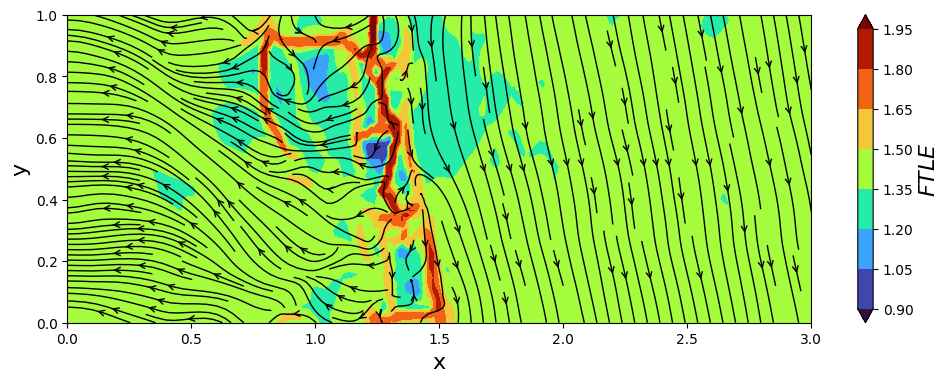

In [28]:
integration_time, dt = 4.5, 0.01   # 5, .01

traj_x, traj_y = get_traj_time_interp(X, Y, U, integration_time, dt)
ftle = get_ftle(traj_x, traj_y, X, Y, integration_time)


fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

contf = pyplot.contourf(X, Y, ftle, extend='both', cmap='turbo')
cbar = pyplot.colorbar(contf)

cbar.set_label('$FTLE$', fontsize=16)
pyplot.streamplot(X, Y, u[0], v[0], density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
pyplot.draw()
pyplot.show()
